In [1]:
import torch
import chirho.contrib.experiments.closed_form as cfe
from torch import tensor as tnsr
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import numpy as np
from typing import Tuple
from chirho.contrib.compexp.handlers.relu_softeners.fill_relu_at_level import FillReluAtLevel

In [2]:
def compute_grad_error(problem: cfe.CostRiskProblem, traj, grads):
    true_grads = torch.stack([problem.ana_loss_grad(tnsr(theta).double()) for theta in traj]).detach().numpy()
    # We don't need to account for this explicitly if its the same for both.
    # cost_grads = torch.stack([problem.cost_grad(tnsr(theta).double().requires_grad_()) for theta in traj]).detach().numpy()

    grad_error = true_grads - grads
    mag_error = np.linalg.norm(grad_error, axis=1)

    # print(true_grads.shape, grads.shape, mag_error.shape)

    return grad_error, mag_error

In [3]:
def get_ellipse_from_std_and_cov(std, cov):
    t = np.linspace(0, 2 * np.pi)
    circle = np.array([np.cos(t), np.sin(t)])
    ellipse = std * np.linalg.cholesky(cov) @ circle
    return ellipse


def visualize_problem(problem: cfe.CostRiskProblem, ax: plt.Axes, err_axs: Tuple[plt.Axes, ...]):
    assert problem.n == 2, "Visualization only supported for 2D problems."

    xl = yl = 9

    # Set lims.
    ax.set_xlim(-xl, xl)
    ax.set_ylim(-yl, yl)

    ax.axhline(0, color='black', linewidth=0.1)
    ax.axvline(0, color='black', linewidth=0.1)

    # Define a grid for plotting
    x, y = np.mgrid[-xl:yl:.01, -xl:yl:.01]
    pos = np.dstack((x, y))

    prob_of_z = multivariate_normal(mean=[0, 0], cov=problem.Sigma).pdf(pos)

    risk_curve = cfe.risk_curve(
        theta=problem.theta0[None, None, :],
        Q=problem.Q[None, None, :, :],
        z=tnsr(pos).double()[:, :, None]).numpy().squeeze()

    # Plot the non-filled contours of the risk_curve.
    ax.contour(x, y, risk_curve, cmap='Reds', linewidths=0.5)
    ax.plot([], [], 'r-', label='risk')

    # Plot the rescaled covariance matrix
    ax.contourf(x, y, prob_of_z, cmap='Blues', alpha=0.9)
    ax.plot([], [], 'b-', label='p(z)')

    ax.set_aspect('equal', 'box')
    # ax.set_title(f'Problem')

    # Plot ellipse by making a unit circle with radius rstar and then transforming it by Sigma.
    ax.plot(*get_ellipse_from_std_and_cov(std=problem.rstar, cov=problem.Sigma), '--', color='darkorange',
            linewidth=0.5, label='~r*')

    # And also plot the ellipse of the initial theta contour.
    ax.plot(*get_ellipse_from_std_and_cov(std=problem.theta0_init_dist, cov=problem.Sigma), '--', color='black',
            linewidth=0.3, label='r0')

    # Plot the gradient vector field of the analytical loss.
    xl = yl = 5
    x, y = np.mgrid[-xl:yl:.5, -xl:yl:.5]
    pos = np.dstack((x, y))
    grad_field = np.array([-problem.ana_loss_grad(tnsr(p).double()).numpy() for p in pos.reshape(-1, 2)]).reshape(
        pos.shape)
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore div by zero warning.
        normed_grad_field = grad_field / np.linalg.norm(grad_field, axis=-1, keepdims=True)

    # Now, color the arrows according to the analytic objective (the negative of the loss).
    objvals = np.array([-problem.ana_loss(tnsr(p).double()).numpy() for p in pos.reshape(-1, 2)]).reshape(
        pos.shape[:-1])

    # Thin arrows.
    ax.quiver(x, y, normed_grad_field[:, :, 0], normed_grad_field[:, :, 1], objvals, cmap='cool',
              alpha=1., scale=100, width=0.0010, headwidth=3, headlength=4, pivot='mid')

    # Remove axis ticks.
    ax.set_xticks([])
    ax.set_yticks([])

    # TODO pull these out into a grouped solve function.
    # <Solve>
    hparams = cfe.Hyperparams(
        lr=5e-3,
        clip=1.0,
        num_steps=3000,
        tabi_num_samples=3,
        decay_at_max_steps=0.5,
        burnin=500,
        ray=False,
        n=problem.n,
        unnorm_const=0.1,
        svi_lr=3e-3
    )
    tabi_hparams = cfe.Hyperparams(
        **hparams.__dict__
    )
    tabi_hparams.clip = 0.1
    
    # <Exact>
    # # Solve the problem with TABI, but with optimal guides (should be equivalent to exact).
    # traj_opt_tabi = cfe.opt_opt_tabi_with_scipy(problem)
    # ax.plot(traj_opt_tabi[:, 0], traj_opt_tabi[:, 1], 'g-', linewidth=0.2, label='opt tabi')
    # # Plot an x at the final solution.
    # ax.plot(traj_opt_tabi[-1, 0], traj_opt_tabi[-1, 1], 'gx', markersize=4, alpha=0.5)

    # Solve the analytic problem with scipy, and plot the trajectory.
    traj_ana = cfe.opt_ana_with_scipy(problem)
    # ax.plot(traj_ana[:, 0], traj_ana[:, 1], 'k--', linewidth=0.2, label='ana bfgs')
    # Plot an x at the final solution.
    ax.plot(traj_ana[-1, 0], traj_ana[-1, 1], 'kx', markersize=5, alpha=0.5)
    # </Exact>
    
    # <SNIS>
    # Solve the problem with SNIS single stage estimator.
    snis_res = cfe.opt_with_snis_sgd(
        problem=problem,
        hparams=tabi_hparams
    )
    ax.plot(snis_res.traj[:, 0], snis_res.traj[:, 1], 'g--', linewidth=0.4, label='sgd snis', alpha=0.5)
    # Mark an x at the mean of the last bit of the trajectory.
    ax.plot(snis_res.traj[-500:, 0].mean(), snis_res.traj[-500:, 1].mean(), 'gx', markersize=5, alpha=0.5)

    _, err_sgd_snis = compute_grad_error(problem=problem, traj=snis_res.traj, grads=snis_res.grad_ests)
    err_axs[2].plot(err_sgd_snis)
    err_axs[2].set_title("SNIS")
    # </SNIS>
    
    # <NoGrad TABI>
    nograd_tabi_res = cfe.opt_with_nograd_tabi_sgd(
        problem=problem,
        hparams=tabi_hparams
    )
    ax.plot(nograd_tabi_res.traj[:, 0], nograd_tabi_res.traj[:, 1], 'c--', linewidth=0.4, label='sgd nograd tabi', alpha=0.5)
    # Mark an x at the mean of the last bit of the trajectory.
    ax.plot(nograd_tabi_res.traj[-500:, 0].mean(), nograd_tabi_res.traj[-500:, 1].mean(), 'cx', markersize=5, alpha=0.5)

    _, err_sgd_nograd_tabi = compute_grad_error(problem=problem, traj=nograd_tabi_res.traj, grads=nograd_tabi_res.grad_ests)
    err_axs[4].plot(err_sgd_nograd_tabi)
    err_axs[4].set_title("NoGrad TABI")
    # </NoGrad TABI>
    
    # <MC>
    # Solve the approximate problem with mc SGD, and plot the trajectory.
    mc_res = cfe.opt_with_mc_sgd(
        problem=problem,
        hparams=hparams,
    )
    ax.plot(mc_res.traj[:, 0], mc_res.traj[:, 1], 'b--', linewidth=0.4, label='sgd mc', alpha=0.5)
    # Mark an x at the mean of the last 100 of the trajectory.
    ax.plot(mc_res.traj[-500:, 0].mean(), mc_res.traj[-500:, 1].mean(), 'bx', markersize=6, alpha=0.5)

    _, err_sgd_mc = compute_grad_error(problem=problem, traj=mc_res.traj, grads=mc_res.grad_ests)
    err_axs[0].plot(err_sgd_mc)
    err_axs[0].set_title("MC")
    # </MC>
    
    # <ZeroVar>
    # Solve the problem with SGD but zero variance.
    zero_var_res = cfe.opt_with_zerovar_sgd(
        problem=problem,
        hparams=hparams
    )
    
    ax.plot(zero_var_res.traj[:, 0], zero_var_res.traj[:, 1], 'k--', linewidth=0.4, label='sgd zero var', alpha=0.5)
    # Mark an x at the mean of the last bit of the trajectory.
    ax.plot(zero_var_res.traj[-500:, 0].mean(), zero_var_res.traj[-500:, 1].mean(), 'kx', markersize=6, alpha=0.5)
    
    # This has no gradient error, so don't bother plotting.
    # </ZeroVar>
    
    # <Posterior Approximating IS>
    # Solve the problem with PAIS single stage estimator.
    pais_res = cfe.opt_with_pais_sgd(
        problem=problem,
        hparams=tabi_hparams
    )
    ax.plot(pais_res.traj[:, 0], pais_res.traj[:, 1], 'm--', linewidth=0.4, label='sgd pais', alpha=0.5)
    # Mark an x at the mean of the last bit of the trajectory.
    ax.plot(pais_res.traj[-500:, 0].mean(), pais_res.traj[-500:, 1].mean(), 'mx', markersize=5, alpha=0.5)

    _, err_sgd_pais = compute_grad_error(problem=problem, traj=pais_res.traj, grads=pais_res.grad_ests)
    err_axs[3].plot(err_sgd_pais)
    err_axs[3].set_title("PAIS")
    # </Posterior Approximating IS>

    # <TABI>
    # Solve problem with TABI single stage estimator.
    with FillReluAtLevel(torch.tensor(0.00001)):
        tabi_res = cfe.opt_with_ss_tabi_sgd(
            problem=problem,
            hparams=tabi_hparams
        )
    ax.plot(tabi_res.traj[:, 0], tabi_res.traj[:, 1], 'r--', linewidth=0.4, label='sgd tabi', alpha=0.5)
    # Mark an x at the mean of the last 100 of the trajectory.
    ax.plot(tabi_res.traj[-500:, 0].mean(), tabi_res.traj[-500:, 1].mean(), 'rx', markersize=5, alpha=0.5)

    _, err_sgd_tabi = compute_grad_error(problem=problem, traj=tabi_res.traj, grads=tabi_res.grad_ests)
    err_axs[1].plot(err_sgd_tabi)
    err_axs[1].set_title("TABI")
    # </TABI>

    # Plot the losses.
    plt.figure(figsize=(12, 4))
    plt.plot(tabi_res.losses, label='tabi')
    plt.plot(mc_res.losses, label='mc')
    plt.plot(snis_res.losses, label='snis')
    plt.plot(zero_var_res.losses, label='zero var')
    # plt.plot(pais_res.losses, label='pais')
    plt.plot(nograd_tabi_res.losses, label='nograd tabi')
    # Plot a horizontal line on the loss plot for the final scipy solution.
    plt.axhline(problem.ana_loss(tnsr(traj_ana[-1]).double()).numpy(), color='black', linewidth=0.5, linestyle='--')
    plt.legend()

    # DEBUG LR
    plt.figure(figsize=(12, 4))
    plt.plot(tabi_res.lrs, label='tabi')
    plt.plot(mc_res.lrs, label='mc')
    plt.plot(snis_res.lrs, label='snis')
    plt.plot(zero_var_res.lrs, label='zero var')
    plt.plot(pais_res.lrs, label='pais')
    plt.plot(nograd_tabi_res.lrs, label='nograd tabi')
    plt.legend()
    # </Solve>

    ax.legend(fontsize=6)

SGD SNIS 03499/3500


/Users/azane/miniconda3/envs/basis_general/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at denormalization_factor
  warnings.warn(


SGD NG TABI 03499/3500
SGD MC 03499/3500
SGD ZV 03499/3500
SGD PAIS 03499/3500
SGD SS TABI 03499/3500


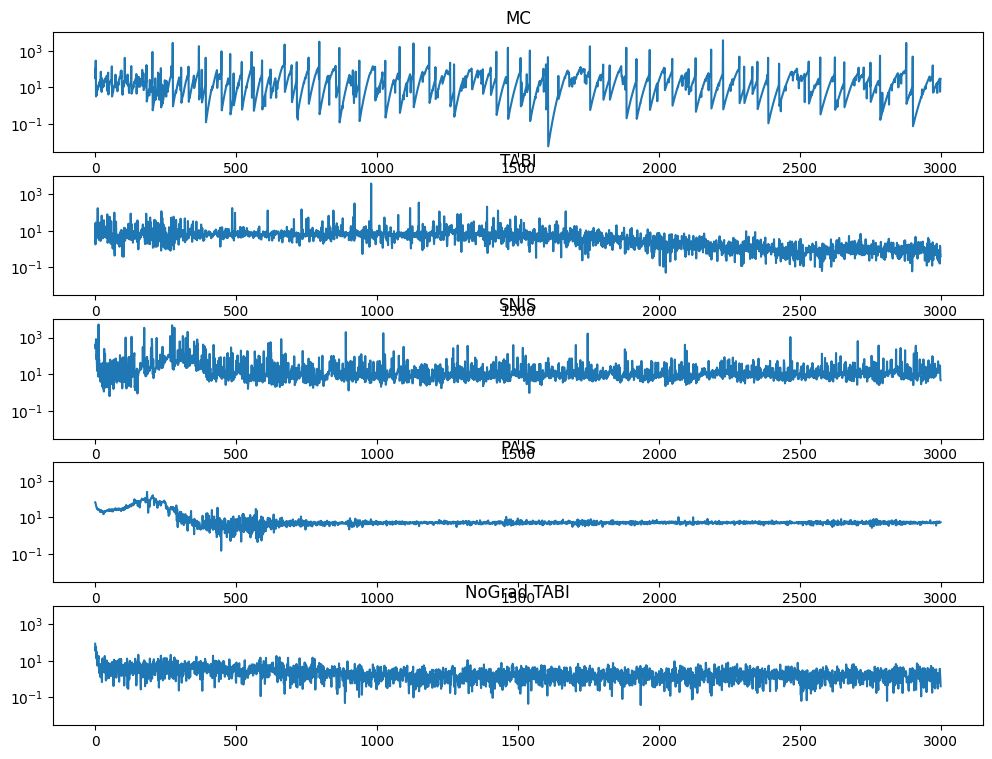

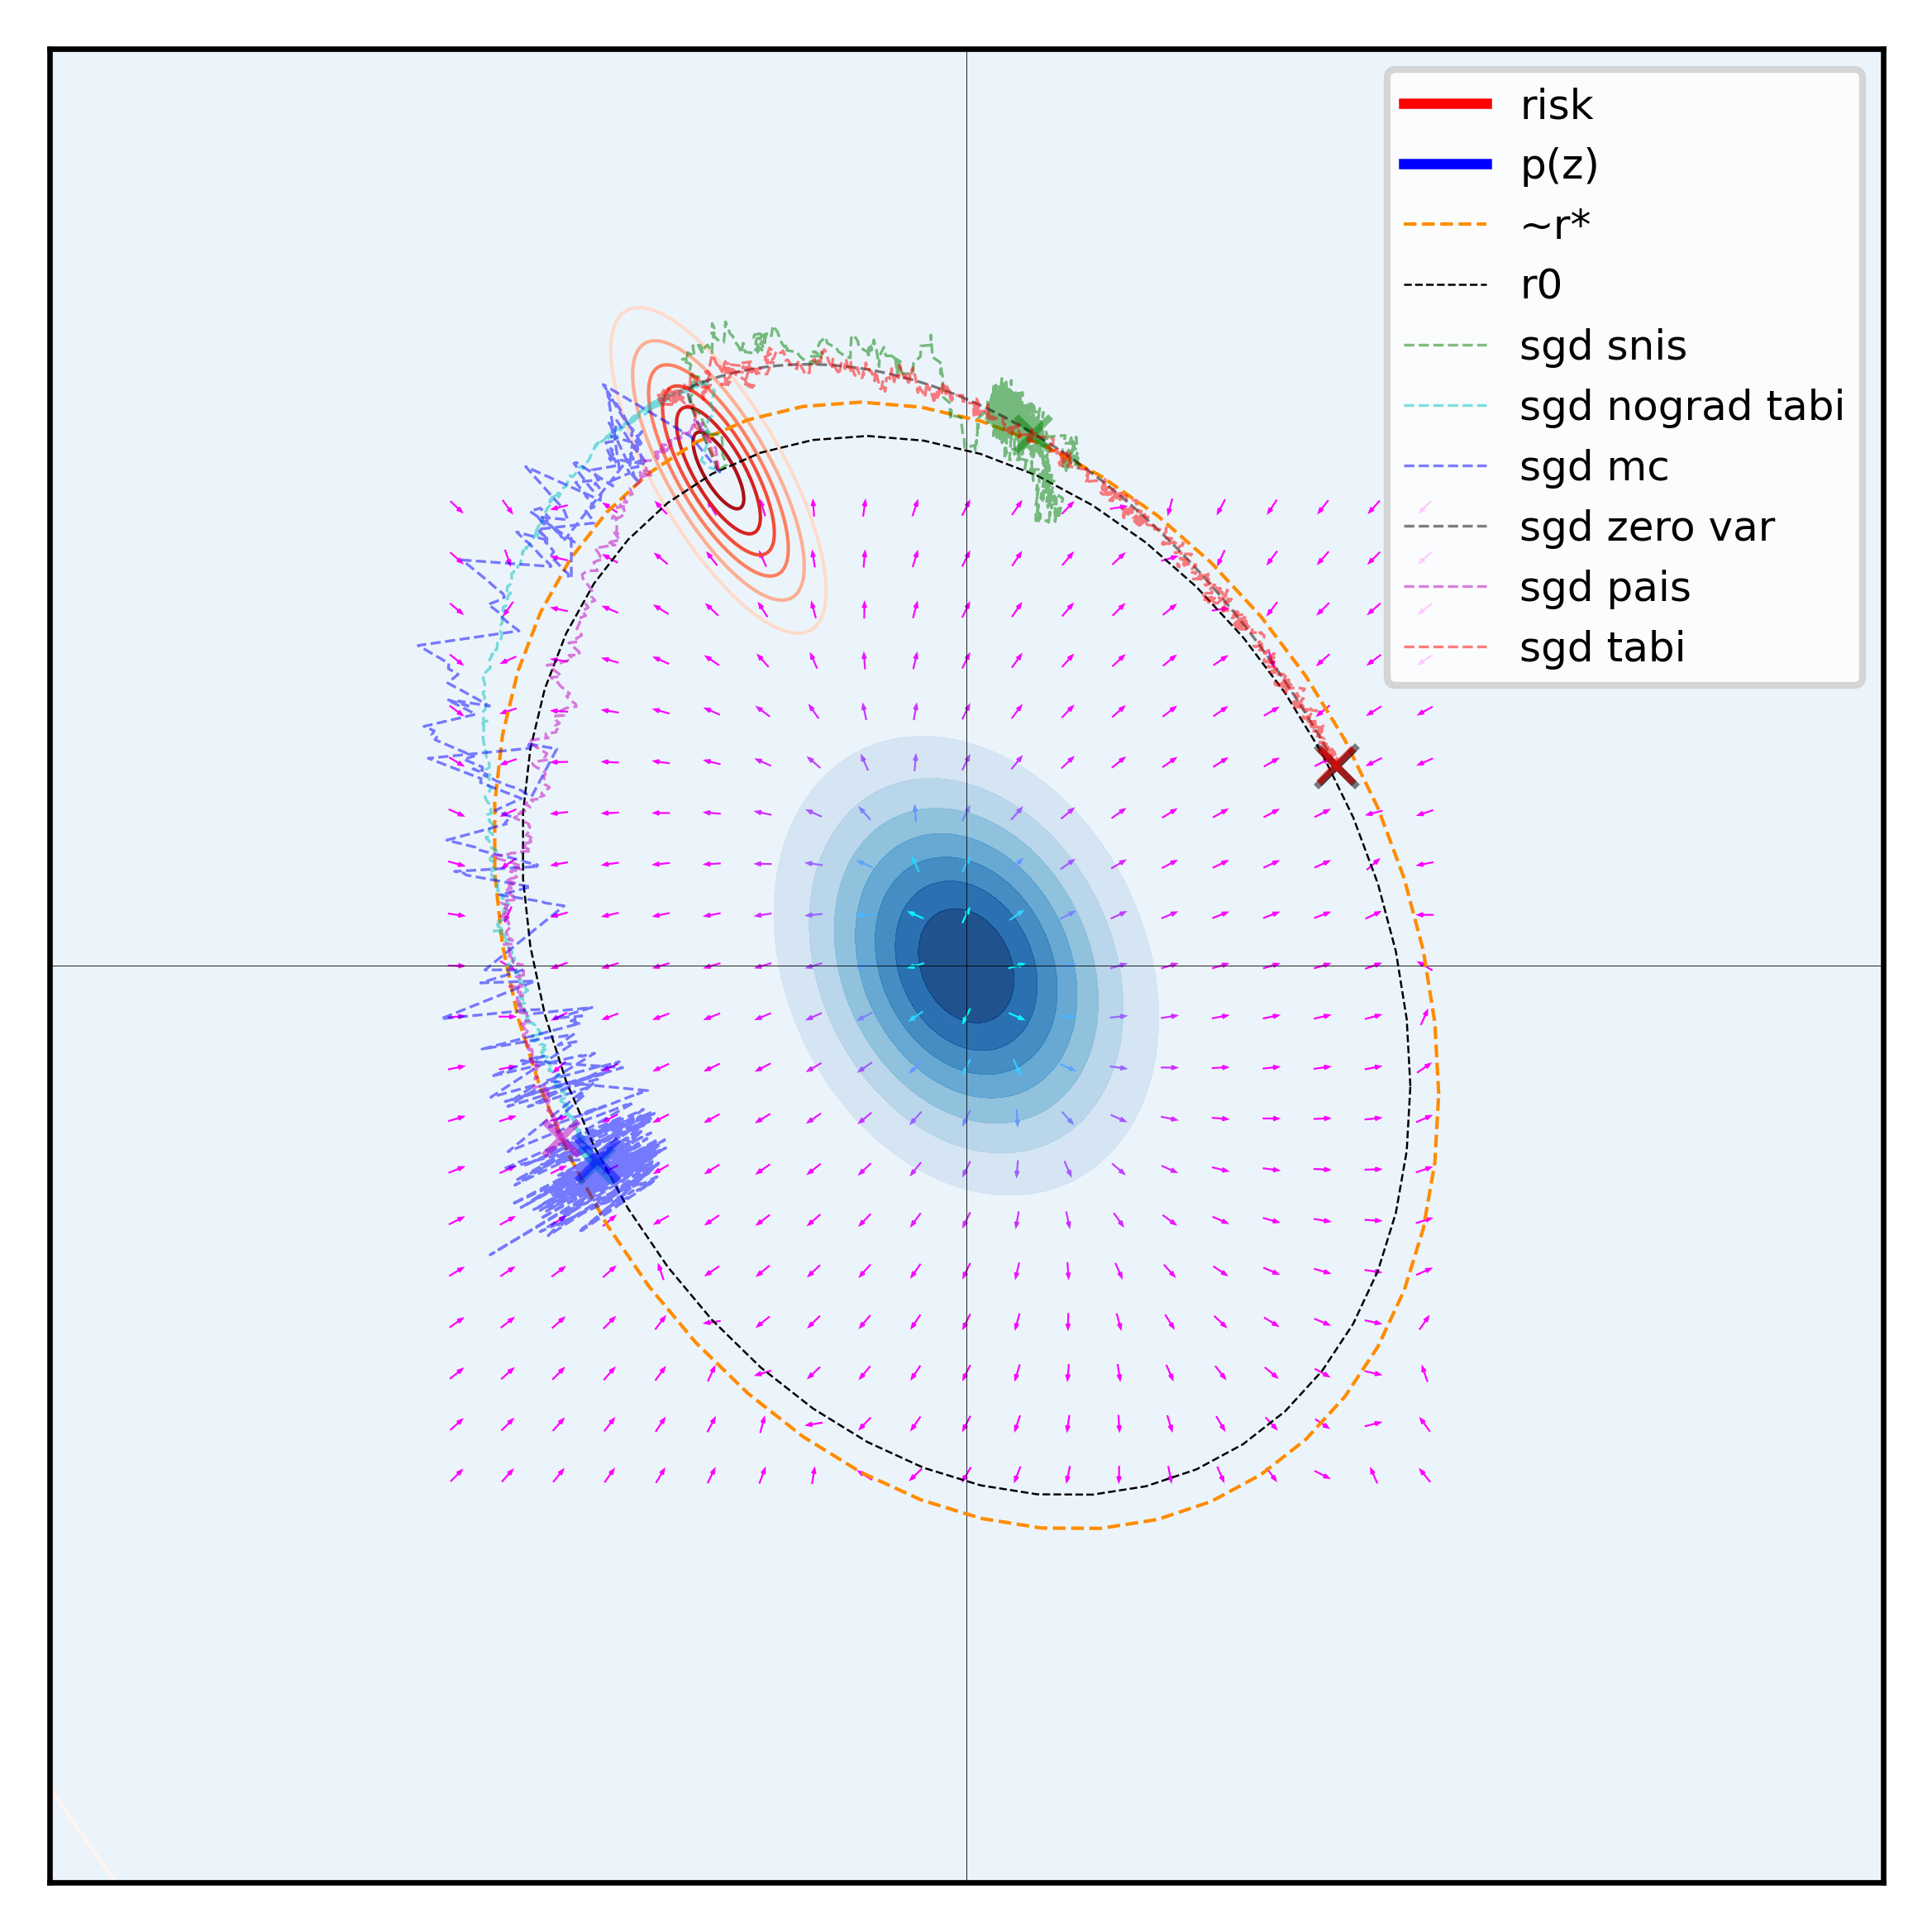

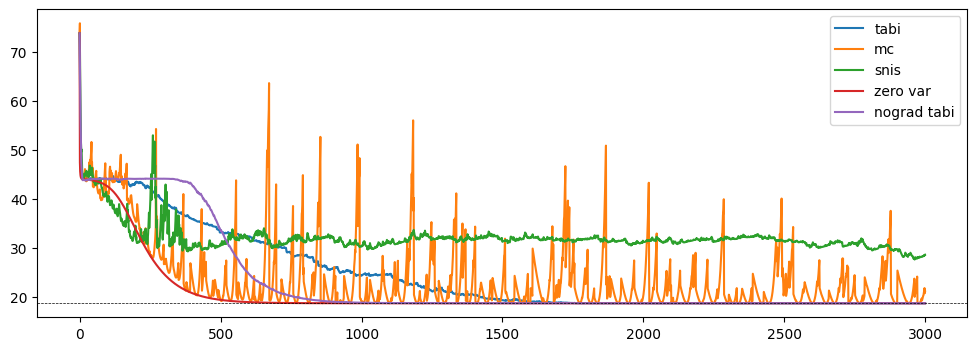

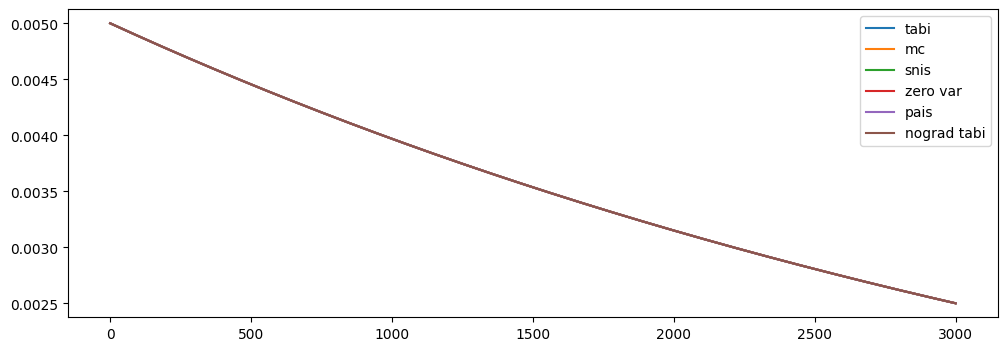

In [4]:
from pyro.util import set_rng_seed
def example_problems():
    set_rng_seed(567)  # problem generation seed.
    problem = cfe.CostRiskProblem(q=0.3, n=2, rstar=5., theta0_rstar_delta=-0.3)
    _, err_axs = plt.subplots(5, 1, figsize=(12, 9), sharey=True)
    _, ax = plt.subplots(1, 1, dpi=600)
    for err_ax in err_axs:
        err_ax.set_yscale('log')
    set_rng_seed(203)  # optimization seed.
    visualize_problem(problem, ax, err_axs)
    # plt.tight_layout()
    plt.show()
example_problems()